<a href="https://colab.research.google.com/github/naenumtou/learnTensorFlow/blob/main/childrenQuotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [ ]:
# Change working directory to store trained model
%cd /content/drive/My Drive/Colab Notebooks/childrenQuotation

/content/drive/My Drive/Colab Notebooks/childrenQuotation


In [ ]:
# Install PyThaiNLP
!pip install --upgrade pythainlp

     |████████████████████████████████| 11.5 MB 5.4 MB/s 


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pythainlp import word_tokenize

# Neural network libraies
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout

# Checking GPU available
if tf.test.gpu_device_name() == '/device:GPU:0':
  print('GPU is available')
else:
  print('GPU is not available')

print(f'Tensorflow version: {tf.__version__}')

# Config 
%config InlineBackend.figure_format = 'retina' #Retina display
pd.set_option('max_colwidth', 999) #Increase columns width
plt.style.use('seaborn-deep') #Plot style

GPU is available
Tensorflow version: 2.8.0


In [ ]:
# Import data
df = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/learnTensorFlow/main/datasets/childrenDay.csv'
)

# Show table
df.head(5)

,year,text
0,2499,จงบำเพ็ญตนให้เป็นประโยชน์ต่อผู้อื่นและส่วนรวม
1,2502,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่รักความก้าวหน้า
2,2503,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่รักความสะอาด
3,2504,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่อยู่ในระเบียบวินัย
4,2505,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่ประหยัด


In [ ]:
# Tokenize text
df['textToken'] = df['text'].apply(
    lambda text: word_tokenize(
        text,
        engine = 'newmm',
        keep_whitespace = False
    )
)

# Show table
df.head(5)

,year,text,textToken
0,2499,จงบำเพ็ญตนให้เป็นประโยชน์ต่อผู้อื่นและส่วนรวม,"[จง, บำเพ็ญตน, ให้, เป็นประโยชน์, ต่อ, ผู้อื่น, และ, ส่วนรวม]"
1,2502,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่รักความก้าวหน้า,"[ขอให้, เด็ก, สมัย, ปฏิวัติ, ของ, ข้าพเจ้า, จง, เป็น, เด็ก, ที่รัก, ความก้าวหน้า]"
2,2503,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่รักความสะอาด,"[ขอให้, เด็ก, สมัย, ปฏิวัติ, ของ, ข้าพเจ้า, จง, เป็น, เด็ก, ที่รัก, ความสะอาด]"
3,2504,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่อยู่ในระเบียบวินัย,"[ขอให้, เด็ก, สมัย, ปฏิวัติ, ของ, ข้าพเจ้า, จง, เป็น, เด็ก, ที่อยู่, ใน, ระเบียบวินัย]"
4,2505,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่ประหยัด,"[ขอให้, เด็ก, สมัย, ปฏิวัติ, ของ, ข้าพเจ้า, จง, เป็น, เด็ก, ที่, ประหยัด]"


In [ ]:
# List to string
df['textToken'] = df['textToken'].apply(
    lambda text: ' '.join(text)
)

# Show table
df.head(5)

,year,text,textToken
0,2499,จงบำเพ็ญตนให้เป็นประโยชน์ต่อผู้อื่นและส่วนรวม,จง บำเพ็ญตน ให้ เป็นประโยชน์ ต่อ ผู้อื่น และ ส่วนรวม
1,2502,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่รักความก้าวหน้า,ขอให้ เด็ก สมัย ปฏิวัติ ของ ข้าพเจ้า จง เป็น เด็ก ที่รัก ความก้าวหน้า
2,2503,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่รักความสะอาด,ขอให้ เด็ก สมัย ปฏิวัติ ของ ข้าพเจ้า จง เป็น เด็ก ที่รัก ความสะอาด
3,2504,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่อยู่ในระเบียบวินัย,ขอให้ เด็ก สมัย ปฏิวัติ ของ ข้าพเจ้า จง เป็น เด็ก ที่อยู่ ใน ระเบียบวินัย
4,2505,ขอให้เด็กสมัยปฏิวัติของข้าพเจ้า จงเป็นเด็กที่ประหยัด,ขอให้ เด็ก สมัย ปฏิวัติ ของ ข้าพเจ้า จง เป็น เด็ก ที่ ประหยัด


### Usage of Keras Tokenizer
The Tokenizer class of Keras is used for vectorizing a text corpus. For this either, each text input is converted into integer sequence or a vector that has a coefficient for each token in the form of binary values.

```python
tokenizer = Tokenizer(lower = False) #Define tokenizer

# Example text
example = [
  'Machine learning model',
  'Deep learning model',
  'Machine Learning',
  'Deep learning'
]

# Fit to text
tokenizer.fit_on_texts(example)
```
Count corpus
```python
print(f'Totol corpus: {tokenizer.document_count}')
```
Result
```python
Totol corpus: 5
```
Count unique words - it shows the number of times words occur
```python
print(f'Words count: {tokenizer.word_counts}')
```
Result
```python
Words count: OrderedDict([('Machine', 2), ('learning', 3), ('model', 2), ('Deep', 2), ('Learning', 1)])
```
It can be seen that lower and upper case are different between `learning` and `Learning` when setting `lower = False`.

The `word_index` assigns a unique index to each word present in the text. This unique integer helps the model during training purposes.
```python
print(f'Words index: {tokenizer.word_index}')
```
Result
```python
Words index: {'learning': 1, 'Machine': 2, 'model': 3, 'Deep': 4, 'Learning': 5}
```

In [ ]:
# Tokenization
tokenizer = Tokenizer() #Thai don't need upper and lower cases

# Fit to corpus
tokenizer.fit_on_texts(df['textToken'])
totalWords = len(tokenizer.word_index) + 1 #word_index start at 1
print(f'Total unique word: {totalWords}')

Total unique word: 189


### texts_to_sequences
The method helps in converting tokens of text corpus into a sequence of integers. Using the same example:
```python
tokenizer = Tokenizer(lower = False) #Define tokenizer

# Example text
example = [
  'Machine learning model',
  'Deep learning model',
  'Machine Learning',
  'Deep learning'
]

# Fit to text
tokenizer.fit_on_texts(example)
sequences = tokenizer.texts_to_sequences(example) #Create token sequential
print(f'Token sequences generated: {sequences}')
```
Result
```python
Token sequences generated: [[2, 1, 3], [4, 1, 3], [2, 5], [4, 1]]
```
Compared to words index
```python
Words index: {'learning': 1, 'Machine': 2, 'model': 3, 'Deep': 4, 'Learning': 5}
```
The texts sequential are generated from words index representation.



In [ ]:
# Convert to sequence of each token
sequencesTokens = []

for token in df['textToken']:
  listToken = tokenizer.texts_to_sequences([token])[0]
  for i in range(1, len(listToken)):
    sequenceToken = listToken[:i + 1] #[:0] cannot be defined as first position
    sequencesTokens.append(sequenceToken)

# Show
sequencesTokens[:7]

[[14, 80],
 [14, 80, 21],
 [14, 80, 21, 81],
 [14, 80, 21, 81, 56],
 [14, 80, 21, 81, 56, 82],
 [14, 80, 21, 81, 56, 82, 39],
 [14, 80, 21, 81, 56, 82, 39, 83]]

In [ ]:
# Show sequences tokens as text
tokenizer.sequences_to_texts(sequencesTokens[:7])

['จง บำเพ็ญตน',
 'จง บำเพ็ญตน ให้',
 'จง บำเพ็ญตน ให้ เป็นประโยชน์',
 'จง บำเพ็ญตน ให้ เป็นประโยชน์ ต่อ',
 'จง บำเพ็ญตน ให้ เป็นประโยชน์ ต่อ ผู้อื่น',
 'จง บำเพ็ญตน ให้ เป็นประโยชน์ ต่อ ผู้อื่น และ',
 'จง บำเพ็ญตน ให้ เป็นประโยชน์ ต่อ ผู้อื่น และ ส่วนรวม']

In [ ]:
# Find maximum length of sequences tokens
maxLength = max([len(x) for x in sequencesTokens])

# Zero padding --> Fill 0 prior sequences tokens
sequencesTokens = pad_sequences(
    sequencesTokens,
    maxlen = maxLength,
    padding = 'pre'
)

# Show zero padding
sequencesTokens[:7]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 80],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 80, 21],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 80, 21, 81],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 80, 21, 81, 56],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 80, 21, 81, 56, 82],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 80, 21, 81, 56, 82, 39],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 14, 80, 21, 81, 56, 82, 39, 83]],
      dtype=int32)

In [ ]:
# Create features and labels
# Features
features = sequencesTokens[:, :-1] #Remove the last word of sentences
features[:7]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 80],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 80, 21],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 80, 21, 81],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 80, 21, 81, 56],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 80, 21, 81, 56, 82],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 14, 80, 21, 81, 56, 82, 39]],
      dtype=int32)

In [ ]:
# Labels
labels = sequencesTokens[:, -1] #Use the last word of sentences as labels
labels[:7]

array([80, 21, 81, 56, 82, 39, 83], dtype=int32)

In [ ]:
# Transform labels to sparse matrix using One-Hot Encoding
labels = to_categorical(
     labels,
     num_classes = totalWords
 )
labels[0] #At index 80

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

In [ ]:
# Show text
print(
    list(
        tokenizer.word_index.keys()
    )[
      list(
          tokenizer.word_index.values()
      ).index(
          np.where(labels[0] == 1)[0]
      )
    ]
)  # Prints george

บำเพ็ญตน


In [ ]:
# Design the Long Short Term Memory (LSTM) Neural Networks
model = Sequential()
model.add(
    Embedding(
        totalWords, output_dim = 128, input_length = features.shape[1]
    )
)
model.add(
    LSTM(
        256, return_sequences = True
    )
)
model.add(Dropout(0.2))
model.add(
    LSTM(
        256, return_sequences = True
    )
)
model.add(Dropout(0.3))
model.add(
    LSTM(128)
)
model.add(Dropout(0.3))
model.add(
    Dense(
        totalWords, activation = 'softmax'
    )
)

# Model overview
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 128)           24192     
                                                                 
 lstm_3 (LSTM)               (None, 15, 256)           394240    
                                                                 
 dropout_3 (Dropout)         (None, 15, 256)           0         
                                                                 
 lstm_4 (LSTM)               (None, 15, 256)           525312    
                                                                 
 dropout_4 (Dropout)         (None, 15, 256)           0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [ ]:
# Define model parameters
EPOCHS = 2000
RATE = 0.0001

# Optimizer
opt = Adam(learning_rate = RATE)

# Compile model
model.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
# Training model
history = model.fit(
    features,
    labels,
    epochs = EPOCHS,
    verbose = 0
)

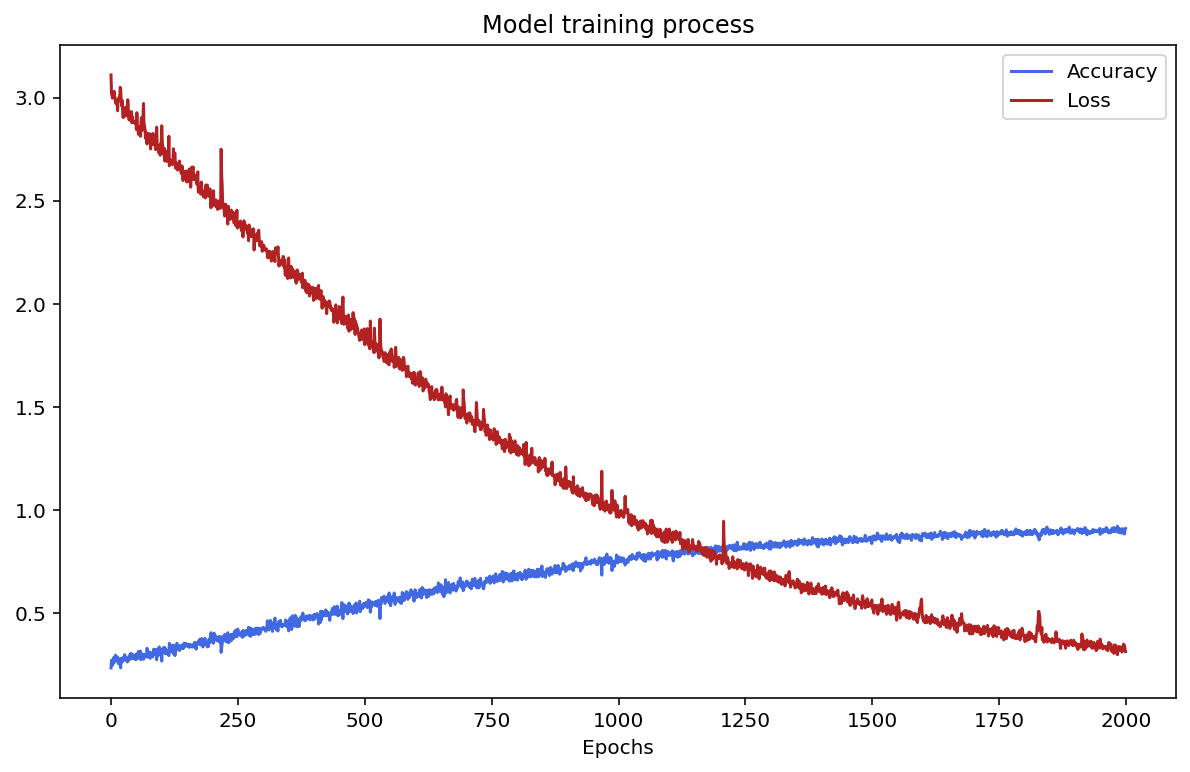

In [ ]:
# Plot
plt.figure(figsize = (10, 6))
plt.plot(
    history.history['accuracy'],
    c = 'royalblue',
    label = 'Accuracy'
)
plt.plot(
    history.history['loss'],
    c = 'firebrick',
    label = 'Loss'
)
plt.legend(frameon = True, facecolor = 'white')
plt.title('Model training process')
plt.xlabel('Epochs')
plt.show()

In [ ]:
# Save model
model.save('childrenQuotation.h5')

In [ ]:
# Model prediction
# Define prediction function
def generateQuotation(text, numWords):
  textOut = ' '.join(word_tokenize(text))
  wordCount = 0
  while wordCount < numWords:
    textList = tokenizer.texts_to_sequences([textOut])[0]
    textList = pad_sequences(
        [textList], #Input as list
        maxlen = maxLength - 1, #-1 to be the same as features
        padding = 'pre'
    )
    predIndex = model.predict(textList, verbose = 0).argmax() #Predict next word
    for word, index in tokenizer.word_index.items():
      if index == predIndex:
        wordNext = word
        break
    textOut += ' ' + wordNext
    wordCount += 1
  return textOut

In [ ]:
# Testing model
texts = ['เด็กยุคใหม่', 'เด็กไทย', 'ชาติไทย', 'ชาติพัฒนา', 'เด็กในวันนี้']

for text in texts:
  print(generateQuotation(text, 6))

เด็ก ยุคใหม่ จิต อาสา ร่วม พัฒนา ชาติ รุ่งเรือง
เด็ก ไทย วิถี ใหม่ รวม ไทย สร้างชาติ ด้วย
ชาติ ไทย ประหยัด เป็น คุณสมบัติ ของ เด็ก ไทย
ชาติ พัฒนา ศาสน์ กษัตริย์ คุณสมบัติ ของ ของ เยาวชน
เด็ก ใน วันนี้ จง หมั่น เรียน เพียร กระ ทำดี
